# ML lecture 2

### Written by Young-Ho Song (RISP, IBS)
2020-06-23

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## CNN
https://developers.google.com/machine-learning/practica/image-classification/exercise-1

https://github.com/watson-ij/knu-keras-tute-2019/blob/master/20190925-mltute-iwatson.org

## GANs

https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889

https://developers.google.com/machine-learning/gan

https://github.com/watson-ij/knu-keras-tute-2019/blob/master/20190925-mltute-iwatson.org

## BNN (Variational layer in tensorflow probabaility) 

This is an introduction of probabilistic programming in tensor flow. 
https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

You may read this blog for the details og BNN. 
http://krasserm.github.io/2019/03/14/bayesian-neural-networks/
(But the code may not work because of some version problem. 
You can use following modified code)

You may think the Variational Layer as replacing weight into distribution of weight. 
So, the probability distribution of weight is described with mean and variance. 
This mean and variance will be trained to get psoterior distribution. 

In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path


sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tf.keras.backend.set_floatx('float64')              

tfd = tfp.distributions

### Define negative log likelihood, Generate data

In [36]:
#define negative log likelihood function
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# generate data with random noise 
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

#def f(x, sigma):
#    epsilon = np.random.randn(*x.shape) * sigma
#    return x + 0.3*np.sin(2*np.pi*(x+epsilon))+ 0.3*np.sin(4*np.pi*(x+epsilon)) +epsilon

train_size = 100
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)

batch_size = train_size

# This function makes a posteriror distribution as Normal distribution
#  mean and variance of weights 
#  will be trained to simulate true posterior . 
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
  ])

#def prior_trainable(kernel_size, bias_size=0, dtype=None):
#  n = kernel_size + bias_size
#  c = np.log(np.expm1(1.))
#  return tf.keras.Sequential([
#      tfp.layers.VariableLayer(2 * n, dtype=dtype),
#      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#          tfd.Normal(loc=t[..., :n], 
#                     scale=1e-5 + tf.nn.softplus(c + t[..., n:]) ),
#          reinterpreted_batch_ndims=1)),
#  ])

# This function returns prior distribution of weights.
# In fact, in this example the prior distribution will be trained too. 
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1.0 ),
            reinterpreted_batch_ndims=1)),
  ])

# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,
                               kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1], scale=1.0 ),
          reinterpreted_batch_ndims=1))  
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

model.fit(X, y,batch_size=4, epochs=550, verbose=False);

# Profit.
#[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(X)
assert isinstance(yhat, tfd.Distribution)

In [37]:
# sampling output 

X_test = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)

y_pred_list=[]
yhats = [model(X_test) for _ in range(200)]

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    y_pred_list.append(m)

y_preds=np.array(y_pred_list)
y_mean = np.mean(y_preds, axis=0)
y_sigma = np.std(y_preds, axis=0)

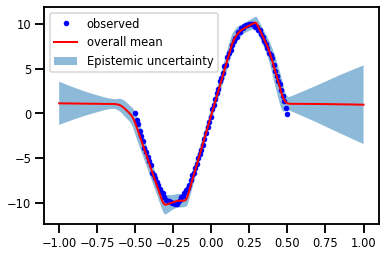

In [41]:
plt.plot(X, y, 'b.', label='observed');
plt.plot(X_test, y_mean , 'r', linewidth=2, label=r'overall mean ');
#plt.plot(X_test, y_mean + 2 * y_sigma, 'g', linewidth=2, label=r'mean + 2 stddev');
#plt.plot(X_test, y_mean - 2 * y_sigma, 'g', linewidth=2, label=r'mean - 2 stddev');
#for _ in range(3):
#    plt.plot(X_test,y_preds[_,:],'y')



plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.legend()

## SVM

https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8

In [31]:
import numpy as np
# import cvxopt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

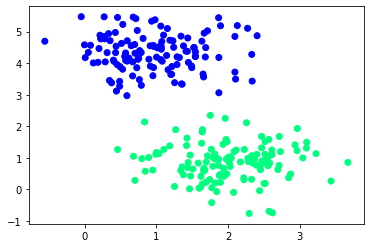

In [32]:
# Make dataset 
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

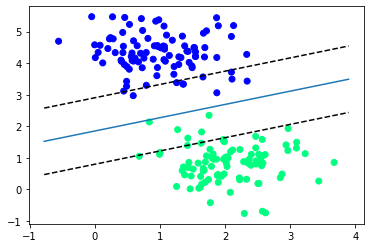

In [33]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Prepare SVM (linear kernel)
svc = LinearSVC()
svc.fit(X_train, y_train)

#plot 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [34]:
# test/predict 
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]], dtype=int64)

## GPs

Based on 
https://krasserm.github.io/2018/03/19/gaussian-processes/


### Define RBF kernel( or Gaussian kernel)

In [9]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# tool to plot Gaussian process 
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

# RBF kernel  
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

## Example of sampling from multivariate normal for given points, mean and kernel  


Suppose we are interested in series of points, X1.(total N points)
With given mean function and kernel(covariance), 
we get mean values (m(x1),m(x2)...m(xN)) and 
covariance matrix $C(i,j) = K(x_i, x_i)$.
Then, probability of values of function at points X1 becomes t =( y(x1), y(x2) ... y(xN) )
is 

$ P(t) = Normal(t; 0, K) = \frac{1}{Z} e^{-\frac{1}{2} t^T C^{-1} t}$


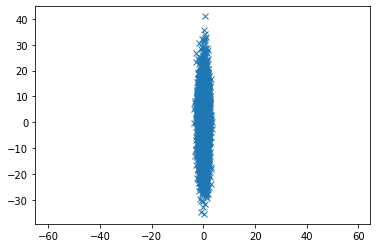

In [10]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

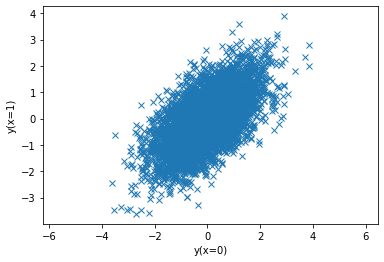

In [11]:
# Correlation between function values at x=0 and x=1 

X = np.array([ [0.],[1.] ])
mean = np.array([0.,0.])
cov = kernel(X,X)

x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.xlabel('y(x=0)')
plt.ylabel('y(x=1)')
plt.axis('equal')
plt.show()

## Prior (no training data is given)

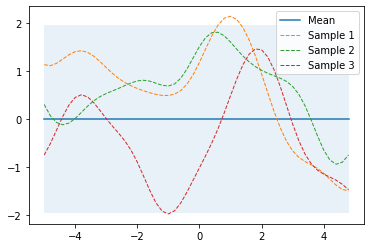

In [12]:
%matplotlib inline

#from gaussian_processes_util import plot_gp

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

### Define posterior 

Posterior probability of function values at new points x_s 
comes from Baye's theorem. 

In [13]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

## Let us set train data

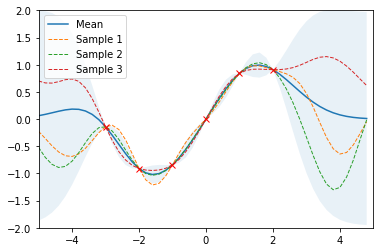

In [24]:
# Noise free training data
noise =0.0
X_train = np.arange(-3, 3, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

# samples according to posterior mean and covariance matrix at new points
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.ylim([-2,2]);plt.xlim([-5,5]);

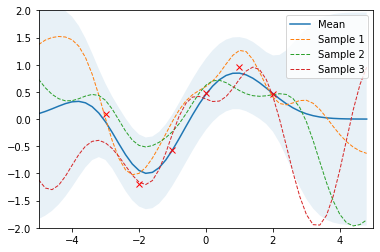

In [27]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 3, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.ylim([-2,2]);plt.xlim([-5,5]);

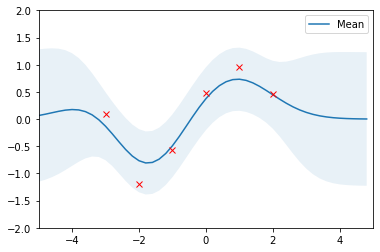

In [28]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
plt.ylim([-2,2]);plt.xlim([-5,5]);

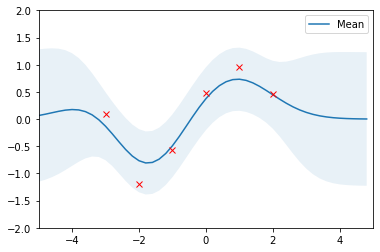

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Compare with previous results
#assert(np.isclose(l_opt, l))
#assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
plt.ylim([-2,2]);plt.xlim([-5,5]);

## VAE

https://keras.io/examples/generative/vae/